Implementation of http://www.jmlr.org/papers/volume12/collobert11a/collobert11a.pdf

In [11]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

### Load Processed data

In [3]:
data_folder = '../data/processed/word_modeling'
indices = 'word_indices.csv'

In [4]:
fourgrams = pd.read_table(os.path.join(data_folder, indices), delimiter=',', nrows=10000000, header=None).values

In [5]:
n = fourgrams.shape[0]
n

10000000

In [6]:
(train_input, train_labels), (valid_input, valid_labels), (test_input, test_labels) = list(map(lambda x: (x[:,:3], x[:,3]), np.split(fourgrams, [int(n * .8), int(n * .9)], axis=0)))

In [7]:
del fourgrams

### Training params

In [60]:
vocab_size = sum([1 for i in open("../data/processed/word_modeling/collobert_word_set_list.txt", encoding="utf-8").readlines()])#train_input.max()#len(word_set_list)
sequence_size = 3 # number of words in the input
numhid1 = 50
batch_size = 500  # Mini-batch size.
learning_rate = 0.1  # Learning rate; default = 0.1.
momentum = 0.9  # Momentum; default = 0.9.
numhid1 = 50  # Dimensionality of embedding space; default = 50.
numhid2 = 200  # Number of units in hidden layer; default = 200.
init_wt = 0.01  # Standard deviation of the normal distribution

In [61]:
vocab_size

2000

##  Window approach Network

### Build computational graph

Uses momentum. No early stopping.

In [65]:
graph = tf.Graph()
with graph.as_default():
    # states: placeholders and constants
    tf_train_dataset = tf.placeholder(tf.int32, [None, sequence_size])
    tf_train_labels = tf.placeholder(tf.int32, [None])
    tf_valid_dataset = tf.constant(valid_input)
    tf_test_dataset = tf.constant(test_input)
    
    
    embedding_layer_state = tf.placeholder(tf.float32, [None, numhid1])
    hidden_layer_state = tf.placeholder(tf.float32, [None, numhid2])
    output_layer_state = tf.placeholder(tf.float32, [None, vocab_size])


    #variables
    word_embedding_weights = tf.Variable(tf.truncated_normal([vocab_size, numhid1], stddev=0.1)) # no bias, table look up
    embed_to_hid_weights = tf.Variable(tf.truncated_normal([numhid1*sequence_size, numhid2], stddev=0.1)) # no bias, word embedding layers
    hid_to_output_weights = tf.Variable(tf.truncated_normal([numhid2, vocab_size], stddev=0.1))
    hid_bias= tf.Variable(tf.zeros([numhid2]))
    output_bias = tf.Variable(tf.zeros([vocab_size]))
    
    # Training computation
    embedding_layer_state = tf.nn.embedding_lookup(params=word_embedding_weights, 
                                                   ids=tf_train_dataset)
    embedding_layer_state = tf.reshape(embedding_layer_state, [-1, numhid1 * sequence_size])
    hidden_layer_state = tf.tanh(tf.matmul(embedding_layer_state, embed_to_hid_weights) + hid_bias, name=None)
    output_layer_state = tf.matmul(hidden_layer_state, hid_to_output_weights) + output_bias
    
    # Loss    
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(output_layer_state, tf_train_labels))
    
    # Optimizer
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(output_layer_state)

    valid_prediction = tf.nn.softmax(
                        tf.matmul(
                            tf.tanh(
                                tf.matmul(tf.reshape(tf.nn.embedding_lookup(word_embedding_weights, 
                                tf_valid_dataset), 
                                [-1, numhid1 * sequence_size]), embed_to_hid_weights) + hid_bias),
                                  hid_to_output_weights) + output_bias)

    test_prediction = tf.nn.softmax(
                        tf.matmul(
                            tf.tanh(
                                tf.matmul(tf.reshape(tf.nn.embedding_lookup(word_embedding_weights, 
                                        tf_test_dataset), 
                                        [-1, numhid1 * sequence_size]), embed_to_hid_weights) + hid_bias, name=None),
                                          hid_to_output_weights) + output_bias)

In [66]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
          / predictions.shape[0])

### Training

In [74]:
num_steps = 100001
config = tf.ConfigProto(
        device_count = {'GPU': 1}
    )

with tf.Session(graph=graph, config=config) as session:
    tf.global_variables_initializer().run()
    
    validation_acc = 0.0
    acc_counter = 0
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
          
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_input[offset:(offset + batch_size), :]
        batch_labels =train_labels[offset:(offset + batch_size)]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions, embeddings = session.run(
          [optimizer, loss, train_prediction, embedding_layer_state], feed_dict=feed_dict)

        if (step % 500 == 0):
            print("Minibatch loss at step", step, ":", l)
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))

        if (step % 1000 == 0):

            new_val_acc = accuracy( valid_prediction.eval(), valid_labels)
            print("Validation accuracy: %.1f%%" % new_val_acc)

            if new_val_acc < validation_acc:
                print("Applying early stopping rule")
                acc_counter += 1
                if acc_counter > 5:
                    print("Validation accuracy decreasing. Applying early stopping")
                    break
            else:
                validation_acc = new_val_acc
                
    embeddings = session.run(word_embedding_weights)


Initialized
Minibatch loss at step 0 : 7.6175
Minibatch accuracy: 0.0%
Validation accuracy: 0.1%
Minibatch loss at step 500 : 5.34598
Minibatch accuracy: 11.6%
Minibatch loss at step 1000 : 4.92757
Minibatch accuracy: 14.6%
Validation accuracy: 15.5%
Minibatch loss at step 1500 : 4.96933
Minibatch accuracy: 14.2%
Minibatch loss at step 2000 : 4.69778
Minibatch accuracy: 18.0%
Validation accuracy: 17.1%
Minibatch loss at step 2500 : 4.63132
Minibatch accuracy: 18.8%
Minibatch loss at step 3000 : 4.69174
Minibatch accuracy: 17.6%
Validation accuracy: 17.7%
Minibatch loss at step 3500 : 4.75361
Minibatch accuracy: 19.0%
Minibatch loss at step 4000 : 4.59946
Minibatch accuracy: 17.8%
Validation accuracy: 18.4%
Minibatch loss at step 4500 : 4.51839
Minibatch accuracy: 20.8%
Minibatch loss at step 5000 : 4.7416
Minibatch accuracy: 18.4%
Validation accuracy: 18.7%
Minibatch loss at step 5500 : 4.47175
Minibatch accuracy: 21.8%
Minibatch loss at step 6000 : 4.44426
Minibatch accuracy: 19.2%
Va

In [75]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
tsne_vecs = model.fit_transform(embeddings) 

In [76]:
vocab = open("../data/processed/word_modeling/collobert_word_set_list.txt", encoding="utf-8").read().splitlines()

In [79]:
fig, ax = plt.subplots(figsize=(70, 70))
ax.scatter(tsne_vecs[:,0], tsne_vecs[:,1])

for i, txt in enumerate(vocab):
    ax.annotate(txt, (tsne_vecs[i,0],tsne_vecs[i,1]))

In [80]:
plt.savefig('collobert_mebedings.png')

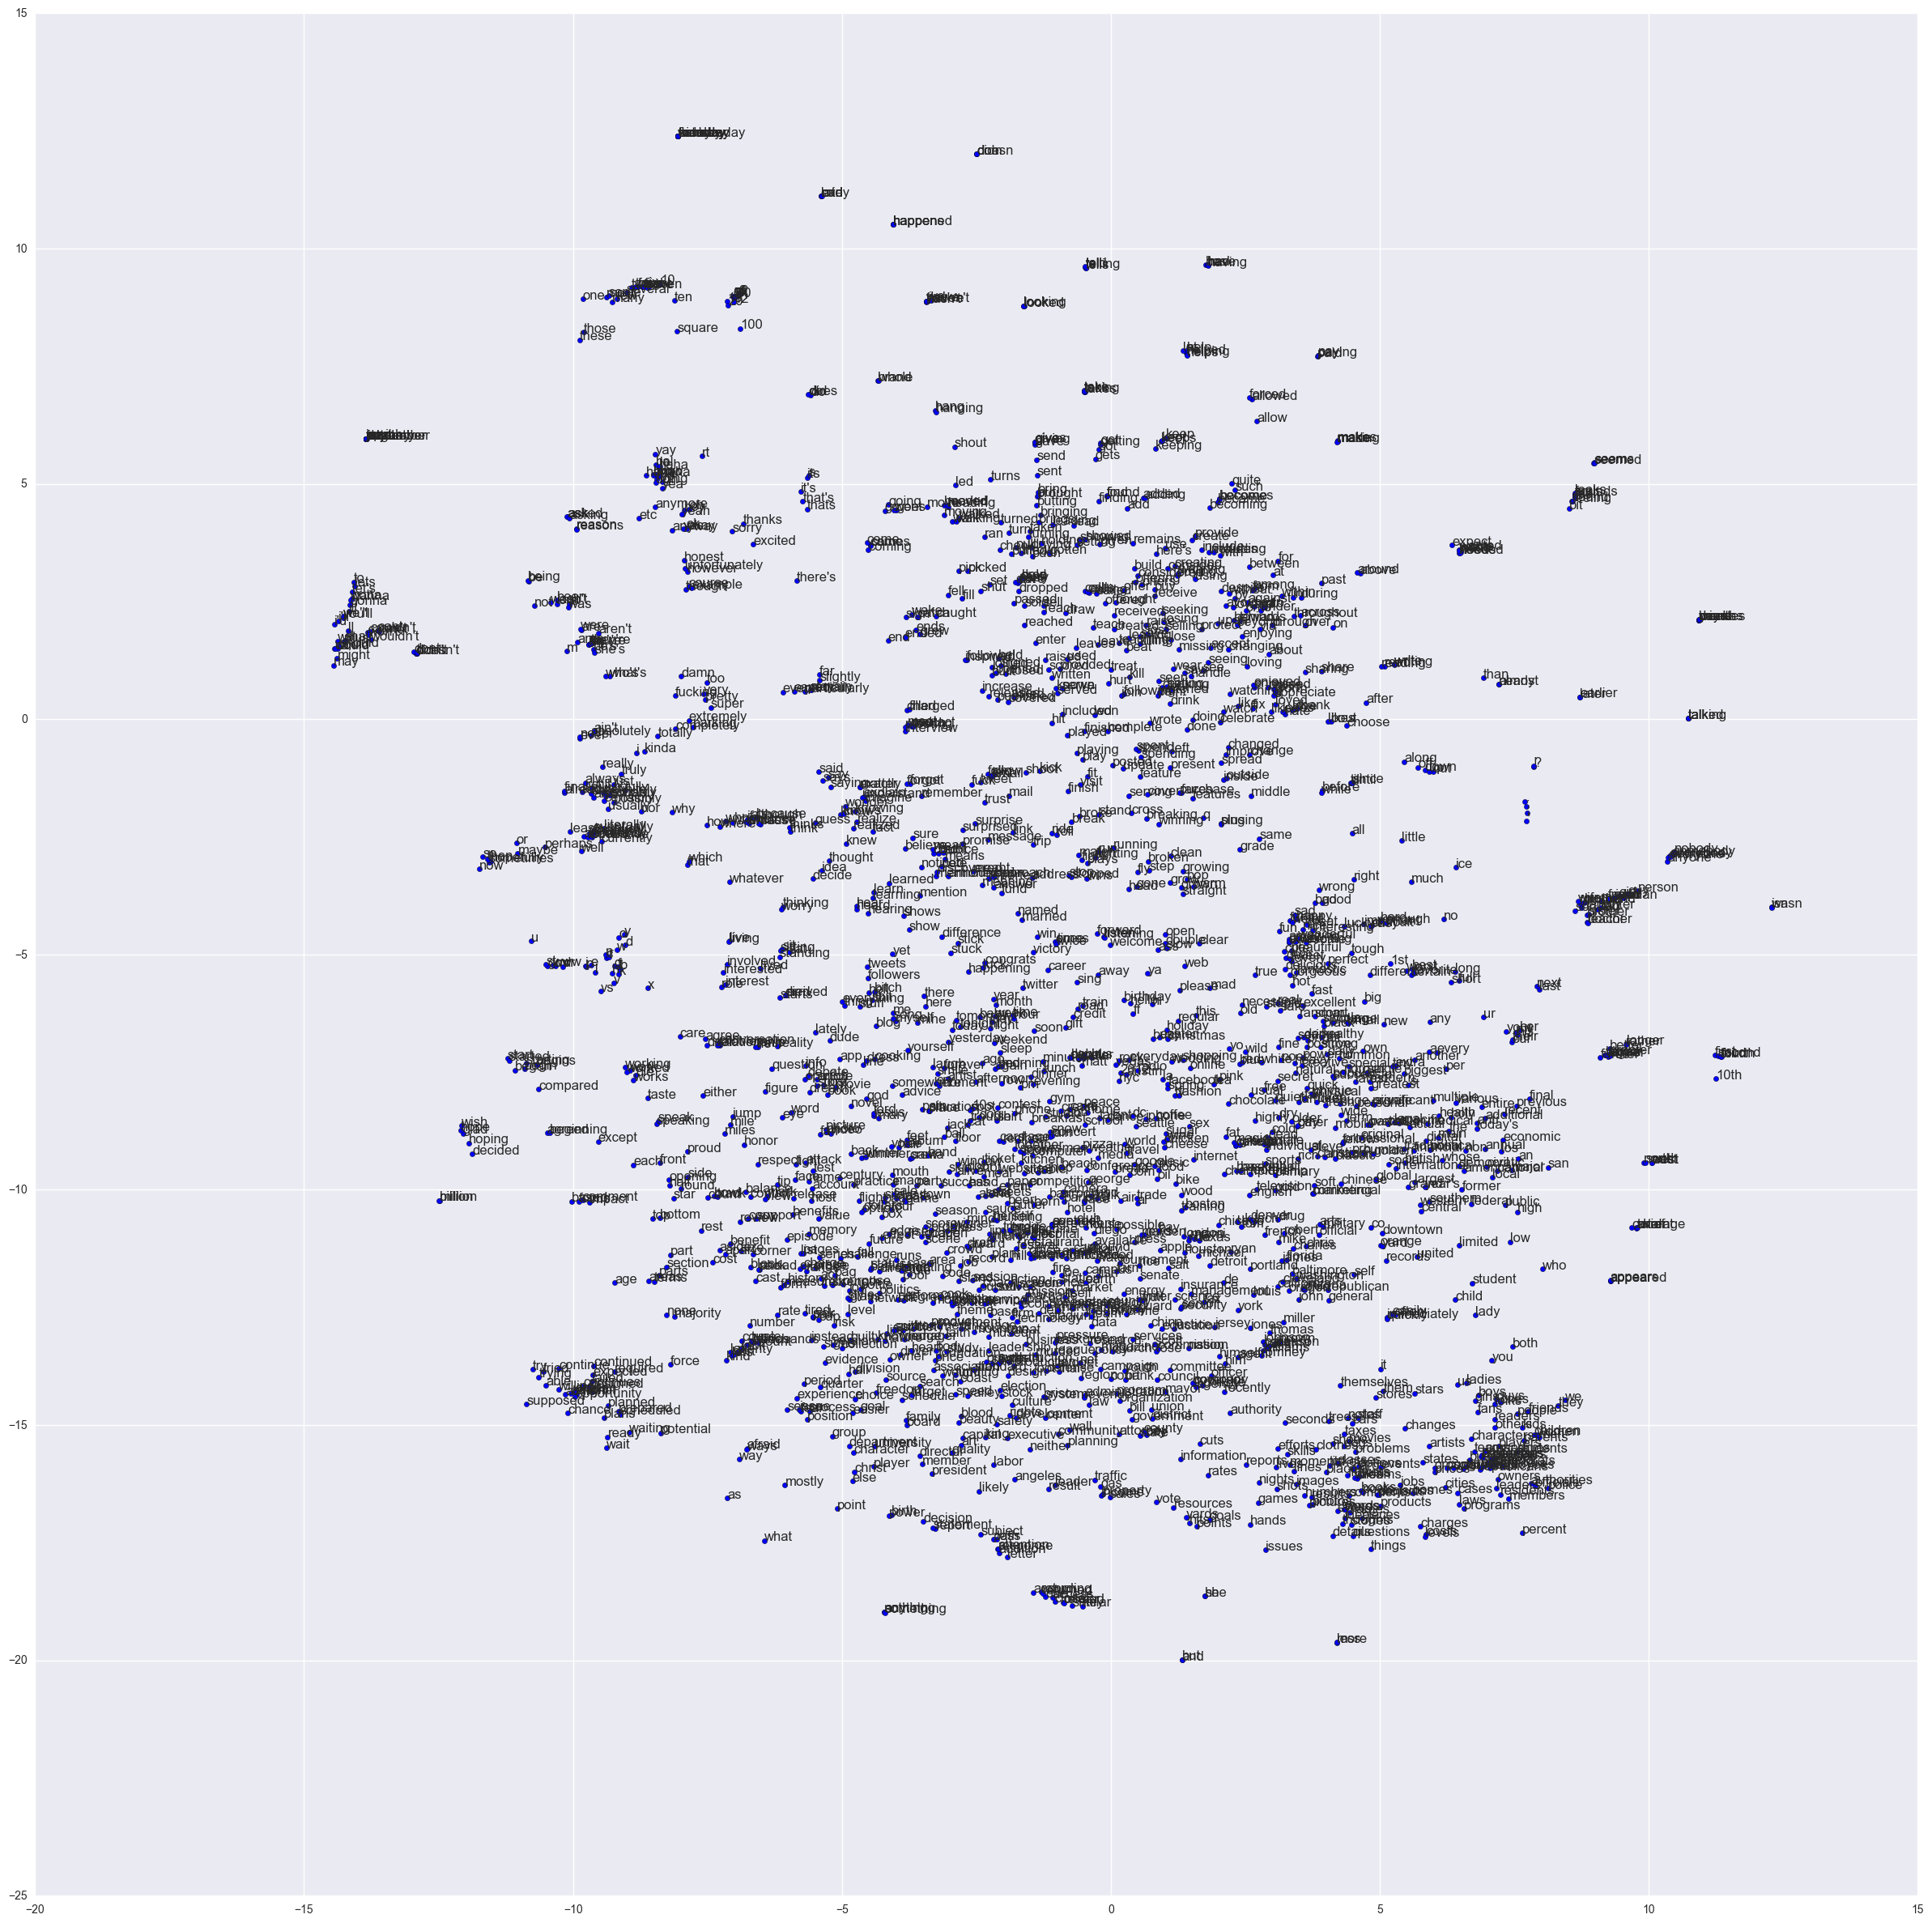

In [71]:
plt.show()